In [52]:
# Import Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Import PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import OneCycleLR

# Import Additional Libraries
from tqdm import tqdm
import time
import os
import warnings
warnings.filterwarnings('ignore')

# Seed for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [53]:
# CNN Architecture for MNIST
class CNNClassMNIST(nn.Module):
    def __init__(self, input_channel=1, filter_size=5, stride=1, num_classes=10):
        super(CNNClassMNIST, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channel, 32, kernel_size=filter_size, stride=stride),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=filter_size, stride=stride),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        self.fc1 = nn.Sequential(
            nn.Linear(4 * 4 * 64, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.adaptive_pool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return x

# CNN Architecture for CIFAR-10
class CNNClassCIFAR10(nn.Module):
    def __init__(self, input_channel=3, filter_size=3, stride=1, num_classes=10):
        super(CNNClassCIFAR10, self).__init__()
        padding = (filter_size - 1) // 2
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channel, 64, kernel_size=filter_size, stride=stride, padding=padding),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=filter_size, stride=stride, padding=padding),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=filter_size, stride=stride, padding=padding),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=filter_size, stride=stride, padding=padding),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=filter_size, stride=stride, padding=padding),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.adaptive_pool(x)
        x = self.fc1(x)
        return x

# Train the model
def train(model, device, train_loader, optimizer, lr_scheduler=None):
    model.train()
    total_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        # Scheduler for CIFAR-10
        if lr_scheduler is not None:
            lr_scheduler.step()

        total_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()

    avg_loss = total_loss / len(train_loader.dataset)
    acc = 100. * correct / len(train_loader.dataset)
    return avg_loss, acc

# Evaluate the model (Val and Test)
def evaluate(model, device, loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    acc = 100. * correct / len(loader.dataset)
    return avg_loss, acc

# Execute the whole experiment, from training to evaluation
def train_model(model, device, train_loader, val_loader, test_loader, learning_rate, epochs=20, weight_decay=0, use_lr_scheduler=False):
    # Optimize with ADAM
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Scheduler for CIFAR-10
    scheduler = None
    if use_lr_scheduler:
        scheduler = OneCycleLR(
            optimizer,
            learning_rate,
            epochs=epochs,
            steps_per_epoch=len(train_loader)
        )

    # Training History
    train_losses, val_losses, test_losses = [], [], []
    train_accs, val_accs, test_accs = [], [], []
    start_time = time.time()
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, device, train_loader, optimizer, lr_scheduler=scheduler)
        val_loss, val_acc = evaluate(model, device, val_loader)
        test_loss, test_acc = evaluate(model, device, test_loader)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Epoch {epoch:}: "
            f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, "
            f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%, "
            f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.2f}%")

    print(f"\nTraining completed in {(time.time() - start_time):.2f} seconds.")
    return train_losses, val_losses, test_losses, train_accs, val_accs, test_accs

# Plot the accuracy curve, loss curve, and historgrams of weights and biases
def plot_curve_and_histogram(model, train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, mnist=True):
    plt.figure(figsize=(12, 20))
    plt.subplot(5,2,1)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()


    plt.subplot(5,2,2)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    def get_data(param):
        return param.detach().cpu().numpy().flatten()

    bins = 50

    plt.subplot(5, 2, 3)
    plt.hist(get_data(model.layer1[0].weight), bins=bins, color='b', alpha=0.7)
    plt.title('Histogram of conv1 (weights)')
    plt.xlabel('Value')
    plt.ylabel('Number')

    plt.subplot(5, 2, 4)
    plt.hist(get_data(model.layer1[0].bias), bins=bins, color='b', alpha=0.7)
    plt.title('Histogram of conv1 (biases)')
    plt.xlabel('Value')
    plt.ylabel('Number')

    plt.subplot(5, 2, 5)
    plt.hist(get_data(model.layer2[0].weight), bins=bins, color='g', alpha=0.7)
    plt.title('Histogram of conv2 (weights)')
    plt.xlabel('Value')
    plt.ylabel('Number')

    plt.subplot(5, 2, 6)
    plt.hist(get_data(model.layer2[0].bias), bins=bins, color='g', alpha=0.7)
    plt.title('Histogram of conv2 (biases)')
    plt.xlabel('Value')
    plt.ylabel('Number')

    plt.subplot(5, 2, 7)
    if (mnist):
        plt.hist(get_data(model.fc1[0].weight), bins=bins, color='r', alpha=0.7)
    else:
        plt.hist(get_data(model.fc1[1].weight), bins=bins, color='r', alpha=0.7)
    plt.title('Histogram of dense1 (weights)')
    plt.xlabel('Value')
    plt.ylabel('Number')

    plt.subplot(5, 2, 8)
    if (mnist):
        plt.hist(get_data(model.fc1[0].bias), bins=bins, color='r', alpha=0.7)
    else:
        plt.hist(get_data(model.fc1[1].bias), bins=bins, color='r', alpha=0.7)
    plt.title('Histogram of dense1 (biases)')
    plt.xlabel('Value')
    plt.ylabel('Number')

    plt.subplot(5, 2, 9)
    if mnist:
        plt.hist(get_data(model.fc1[2].weight), bins=bins, color='purple', alpha=0.7)
    else:
        plt.hist(get_data(model.fc1[4].weight), bins=bins, color='purple', alpha=0.7)
    plt.title('Histogram of output (weights)')
    plt.xlabel('Value')
    plt.ylabel('Number')

    plt.subplot(5, 2, 10)
    if mnist:
        plt.hist(get_data(model.fc1[2].bias), bins=bins, color='purple', alpha=0.7)
    else:
        plt.hist(get_data(model.fc1[4].bias), bins=bins, color='purple', alpha=0.7)
    plt.title('Histogram of output (biases)')
    plt.xlabel('Value')
    plt.ylabel('Number')

    plt.tight_layout()
    plt.show()

# Show the correcly-predicted images and incorrectly-predicted images
def visualize_predictions(model, test_loader, device, cifar=False):
    model.eval()

    correct_images = []
    correct_labels = []
    correct_preds = []

    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []

    if cifar:
        cifar10_mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1).to(device)
        cifar10_std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1).to(device)
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.shape[0]):
                image = images[i]
                label = labels[i]
                pred = preds[i]
                
                if cifar:
                    image = image * cifar10_std + cifar10_mean
                    image = torch.clamp(image, 0, 1)

                if label == pred:
                    if len(correct_images) < 3:
                        if cifar:
                            correct_images.append(image.cpu())
                        else:
                            correct_images.append(image.cpu().squeeze())
                        correct_labels.append(label.cpu().item())
                        correct_preds.append(pred.cpu().item())
                else:
                    if len(incorrect_images) < 3:
                        if cifar:
                            incorrect_images.append(image.cpu())
                        else:
                            incorrect_images.append(image.cpu().squeeze())
                        incorrect_labels.append(label.cpu().item())
                        incorrect_preds.append(pred.cpu().item())

            if len(correct_images) == 3 and len(incorrect_images) == 3:
                break

    plt.figure(figsize=(12, 8))

    for i in range(3):
        plt.subplot(2, 3, i + 1)
        if cifar:
            img_to_plot = correct_images[i].permute(1, 2, 0)
            plt.imshow(img_to_plot)
        else:
            plt.imshow(correct_images[i], cmap='gray')
        plt.title(f"Label: {correct_labels[i]}, Pred: {correct_preds[i]}", color='green')
        plt.axis('off')

    for i in range(3):
        plt.subplot(2, 3, i + 4)
        if cifar:
            img_to_plot = incorrect_images[i].permute(1, 2, 0)
            plt.imshow(img_to_plot)
        else:
            plt.imshow(incorrect_images[i], cmap='gray')
        plt.title(f"Label: {incorrect_labels[i]}, Pred: {incorrect_preds[i]}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return correct_images, correct_labels, correct_preds, incorrect_images, incorrect_labels, incorrect_preds

# Visualize the Feature Maps for 10 channels
def visualize_feature_maps_side_by_side(model, image, label, pred, device, max_maps=10, cifar=False):
    model.eval()

    with torch.no_grad():
        if cifar:
            image_tensor = image.to(device).unsqueeze(0)
        else:
            image_tensor = image.to(device).unsqueeze(0).unsqueeze(0)
        feature_map_1 = model.layer1(image_tensor)
        feature_map_2 = model.layer2(feature_map_1)

    if cifar:
        image_np = image.cpu().permute(1, 2, 0).numpy()
    else:
        image_np = image.cpu().squeeze().numpy()
    fmap1_np = feature_map_1.cpu().squeeze(0).numpy()
    fmap2_np = feature_map_2.cpu().squeeze(0).numpy()

    # Layer 1 plotting
    fig = plt.figure(figsize=(15, 6))
    gs_main = gridspec.GridSpec(1, 2, width_ratios=[1, 3])

    ax_orig = fig.add_subplot(gs_main[0])
    if cifar:
        ax_orig.imshow(image_np)
    else:
        ax_orig.imshow(image_np, cmap='gray')
    ax_orig.set_title(f"Original Image (Label: {label}, Pred: {pred})")
    ax_orig.axis('off')

    gs_maps = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs_main[1], wspace=0.1, hspace=0.1)

    for i in range(max_maps):
        ax_map = fig.add_subplot(gs_maps[i // 5, i % 5])
        ax_map.imshow(fmap1_np[i], cmap='gray')
        ax_map.set_title(f"Channel {i+1}")
        ax_map.axis('off')

    plt.suptitle("Feature Maps from Layer 1", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Layer 2 plotting
    fig = plt.figure(figsize=(15, 6))
    gs_main = gridspec.GridSpec(1, 2, width_ratios=[1, 3])

    ax_orig = fig.add_subplot(gs_main[0])
    if cifar:
        ax_orig.imshow(image_np)
    else:
        ax_orig.imshow(image_np, cmap='gray')
    ax_orig.set_title(f"Original Image (Label: {label}, Pred: {pred})")
    ax_orig.axis('off')

    gs_maps = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs_main[1], wspace=0.1, hspace=0.1)

    for i in range(max_maps):
        ax_map = fig.add_subplot(gs_maps[i // 5, i % 5])
        ax_map.imshow(fmap2_np[i], cmap='gray')
        ax_map.set_title(f"Channel {i+1}")
        ax_map.axis('off')

    plt.suptitle("Feature Maps from Layer 2", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
# Set Hyperparameters
batch_size = 256
epochs = 15
learning_rate = 0.001

# Just convert to Tensor, no pre-processing
transform = transforms.Compose([
    transforms.ToTensor()
])

# Retrieve the MNIST dataset from PyTorch
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split into Train (55000) and Validation (5000)
train_size = 55000
val_size   = 5000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Declare the model
model = CNNClassMNIST(
    input_channel=1,
    filter_size=5,
    stride=3,
    num_classes=10
).to(device)

# Train the model
train_losses, val_losses, test_losses, train_accs, val_accs, test_accs = train_model(model, device, train_loader, val_loader, test_loader, learning_rate, epochs, weight_decay=0)

# Plot the loss and accuracy curve + the histogram for weights and biases
plot_curve_and_histogram(model, train_losses, val_losses, test_losses, train_accs, val_accs, test_accs)

# Visualize some correctly predicted image and incorrectly predicted image
correct_images, correct_labels, correct_preds, incorrect_images, incorrect_labels, incorrect_preds = visualize_predictions(model, test_loader, device)

# Visualize the feature maps for some channels (correct prediction)
visualize_feature_maps_side_by_side(model, correct_images[0], correct_labels[0], correct_preds[0], device)

# Visualize the feature maps for some channels (incorrect prediction)
visualize_feature_maps_side_by_side(model, incorrect_images[0], incorrect_labels[0], incorrect_preds[0], device)

Epoch 1: Train Loss=1.5890, Train Acc=41.28%, Val Loss=1.4203, Val Acc=48.36%, Test Loss=1.3889, Test Acc=49.47%
Epoch 2: Train Loss=1.2769, Train Acc=53.97%, Val Loss=1.2454, Val Acc=55.24%, Test Loss=1.2523, Test Acc=54.18%
Epoch 3: Train Loss=1.1278, Train Acc=59.82%, Val Loss=1.2040, Val Acc=57.44%, Test Loss=1.2151, Test Acc=57.41%
Epoch 4: Train Loss=1.0477, Train Acc=62.89%, Val Loss=1.2079, Val Acc=59.44%, Test Loss=1.2000, Test Acc=60.62%
Epoch 5: Train Loss=1.0121, Train Acc=64.52%, Val Loss=1.0619, Val Acc=63.16%, Test Loss=1.0519, Test Acc=63.39%
Epoch 6: Train Loss=0.9675, Train Acc=66.32%, Val Loss=0.8832, Val Acc=68.74%, Test Loss=0.8756, Test Acc=69.73%
Epoch 7: Train Loss=0.8925, Train Acc=69.19%, Val Loss=1.3564, Val Acc=56.42%, Test Loss=1.3444, Test Acc=56.40%
Epoch 8: Train Loss=0.8299, Train Acc=71.36%, Val Loss=1.2891, Val Acc=58.76%, Test Loss=1.2981, Test Acc=59.33%
Epoch 9: Train Loss=0.7872, Train Acc=73.23%, Val Loss=1.1416, Val Acc=64.00%, Test Loss=1.1184,

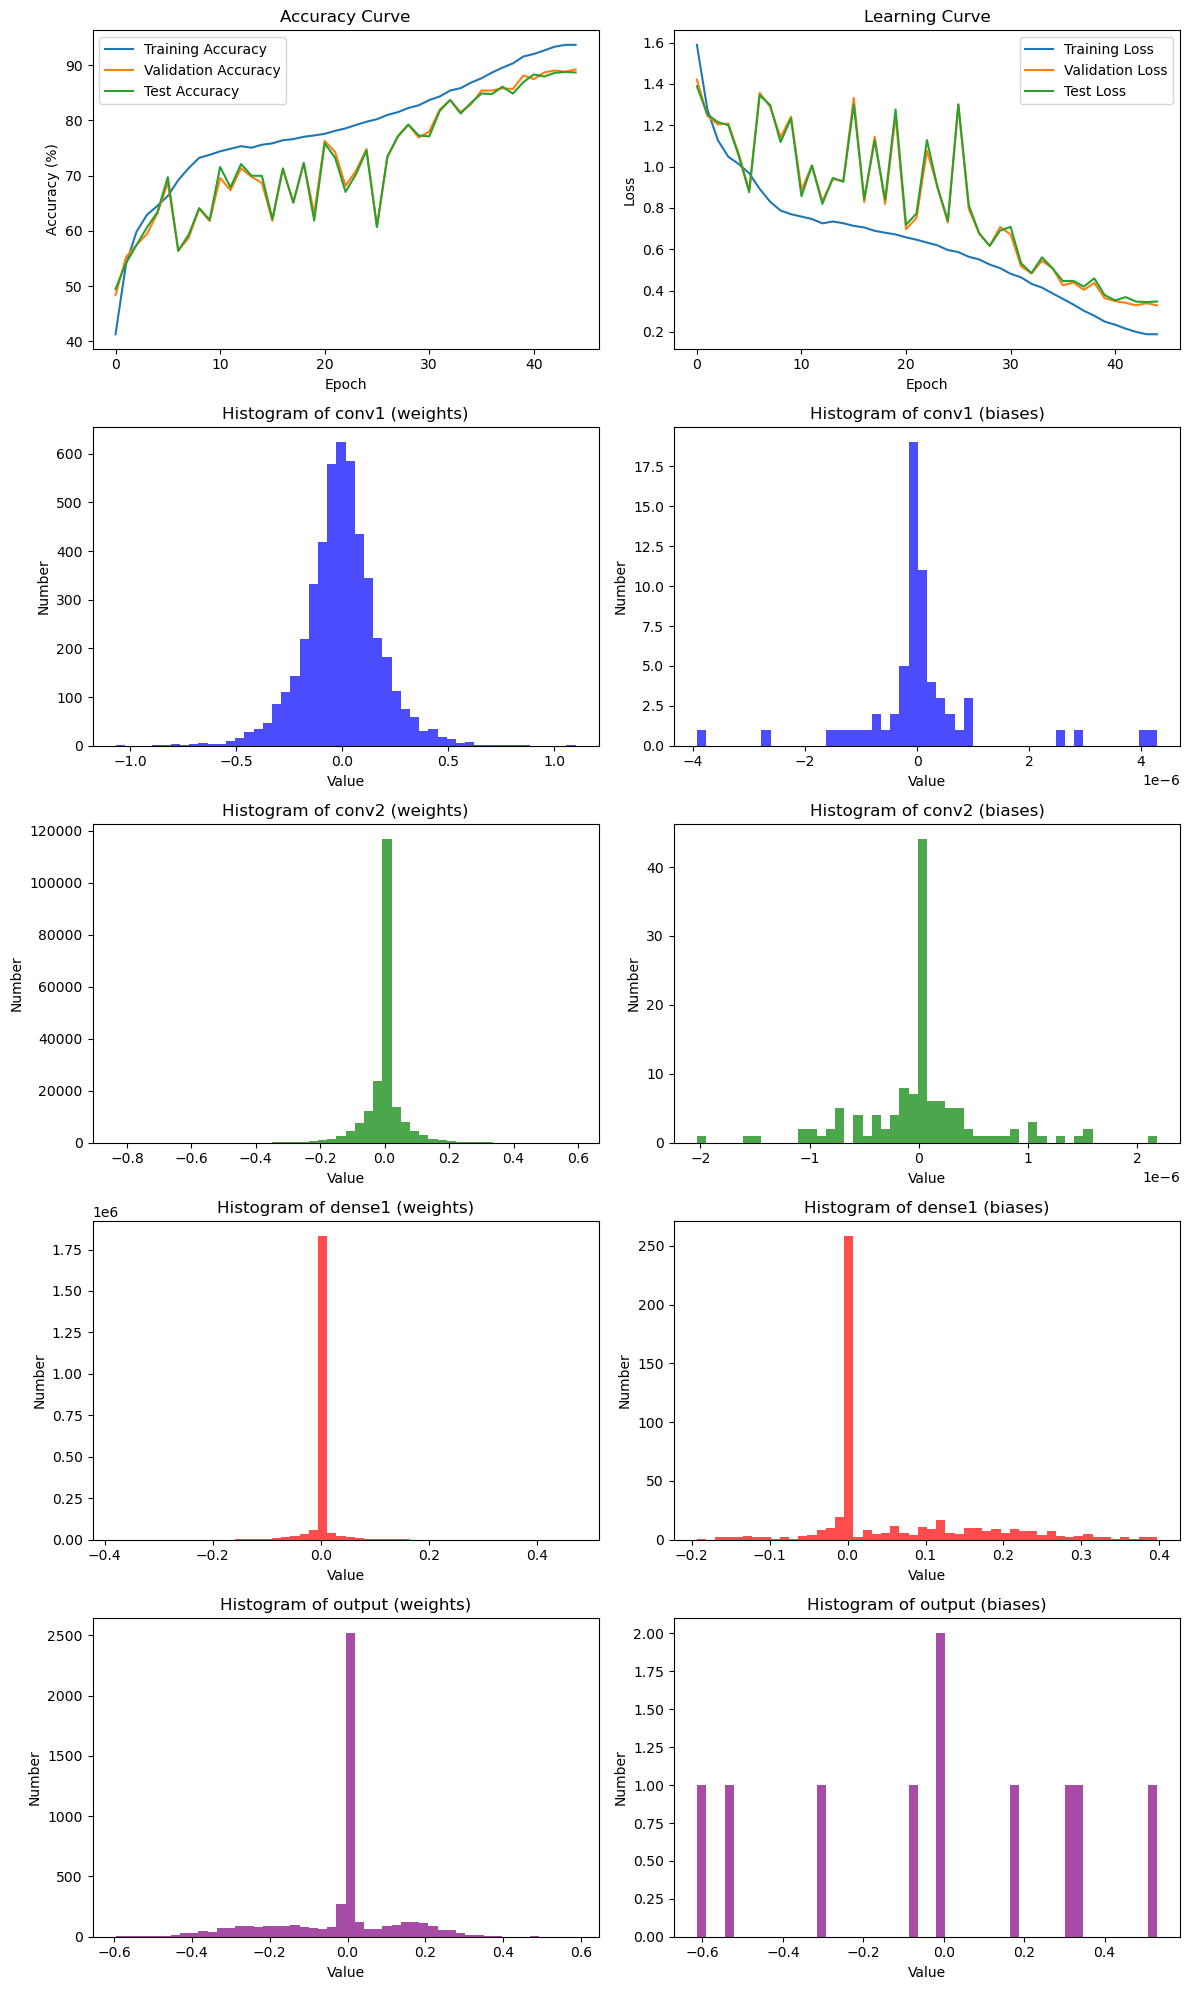

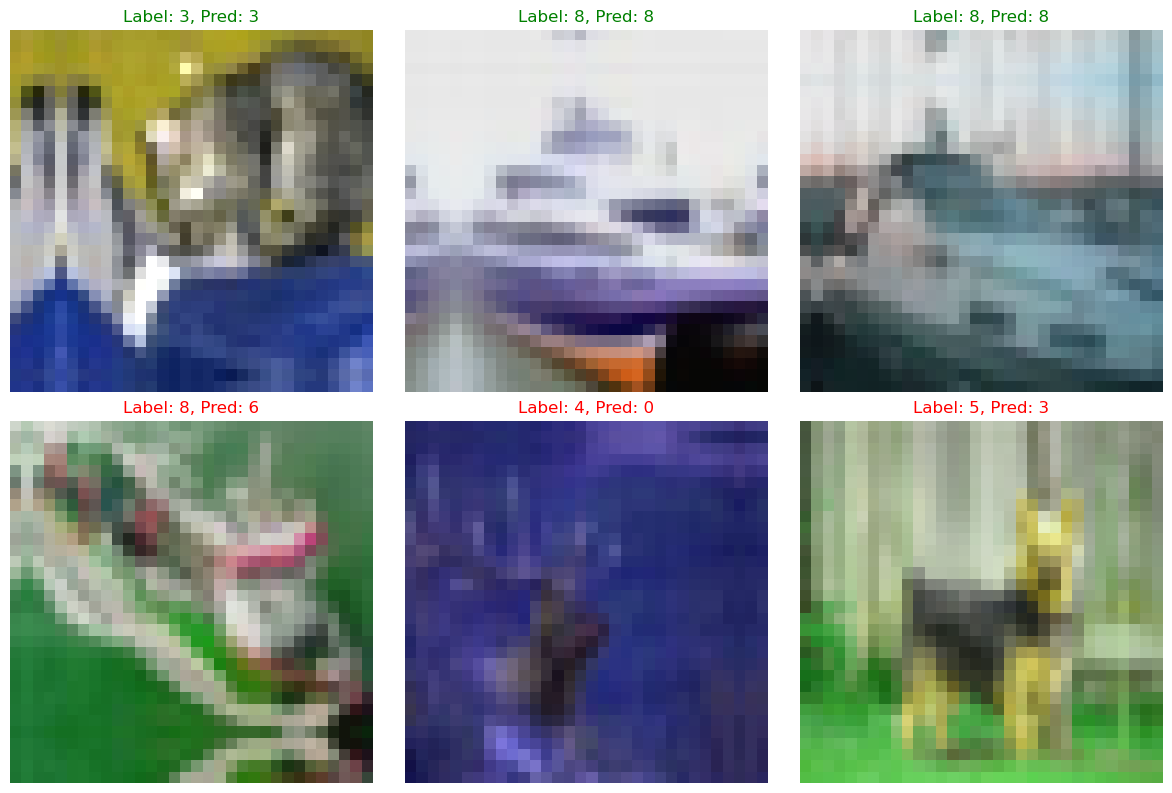

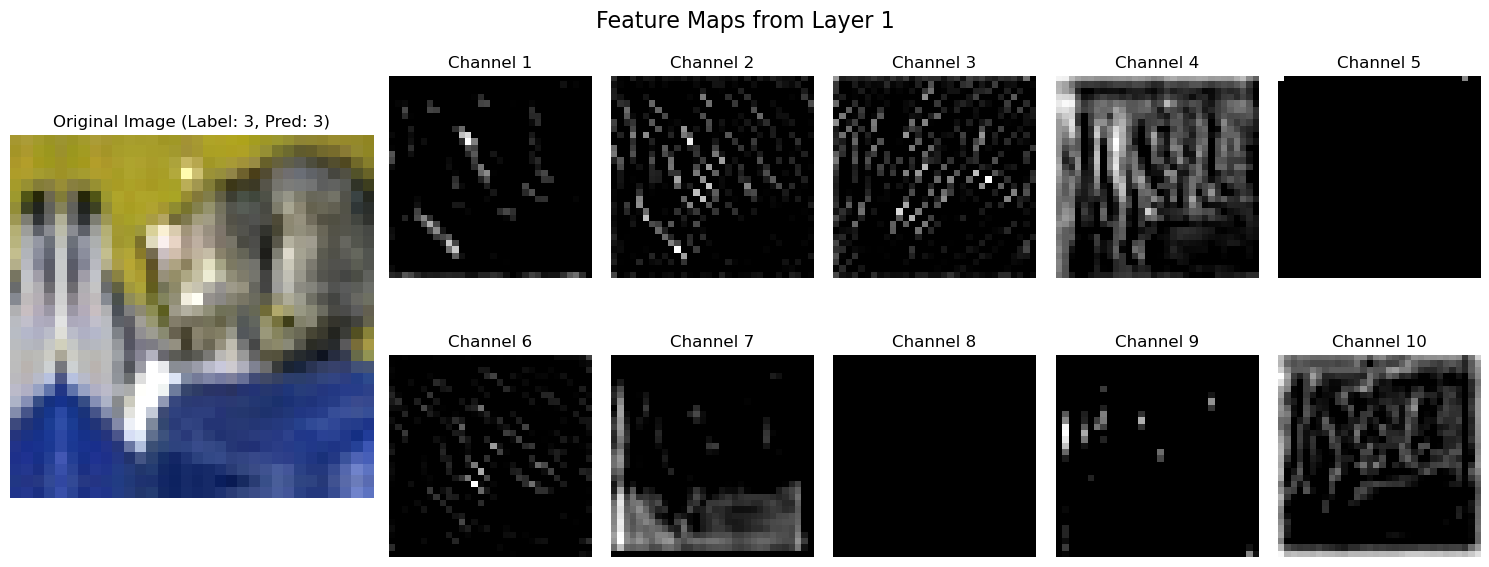

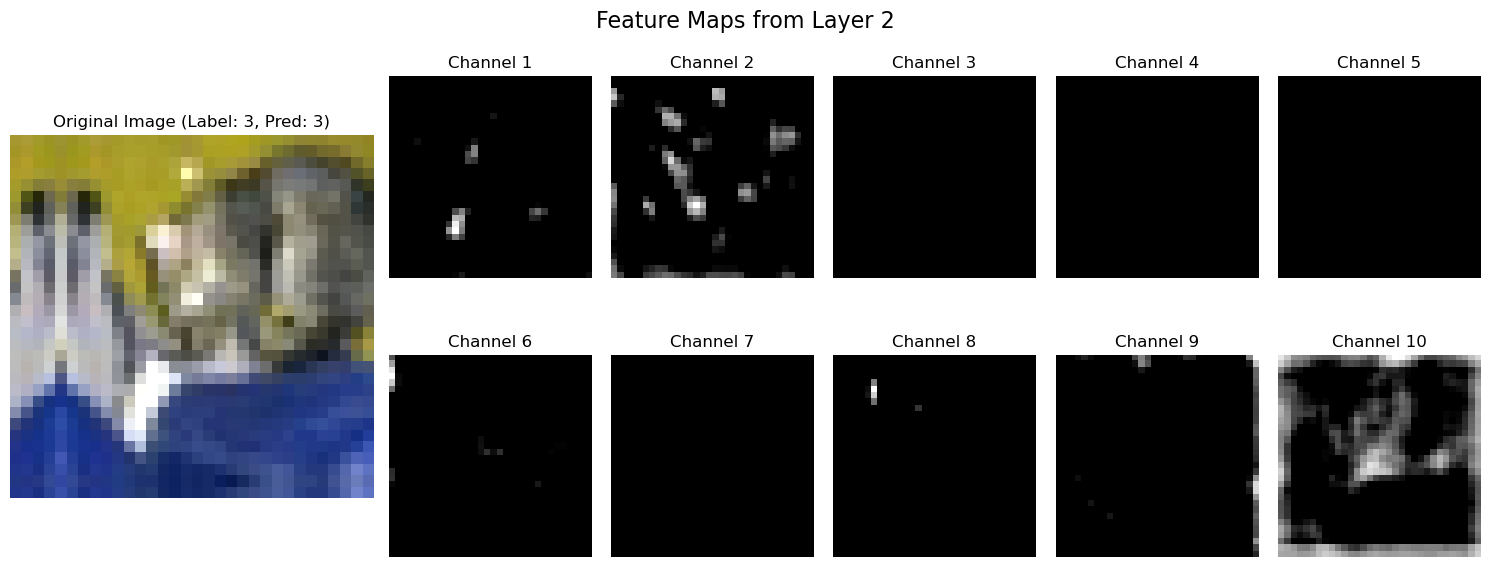

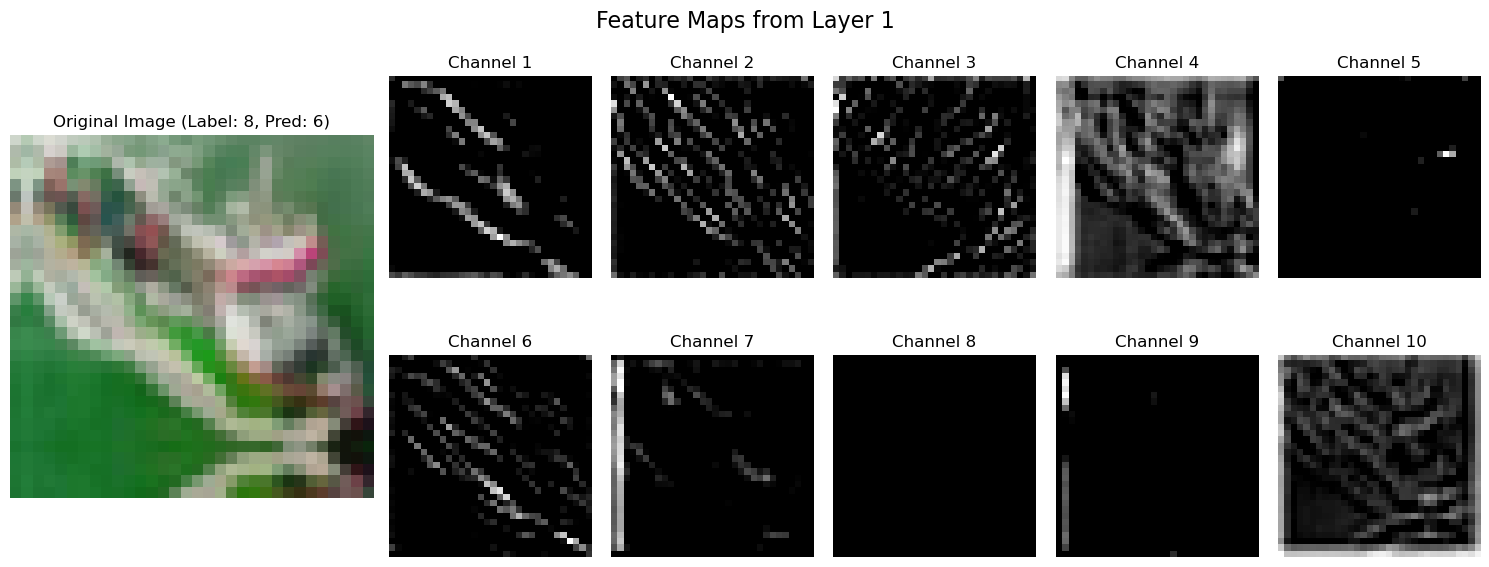

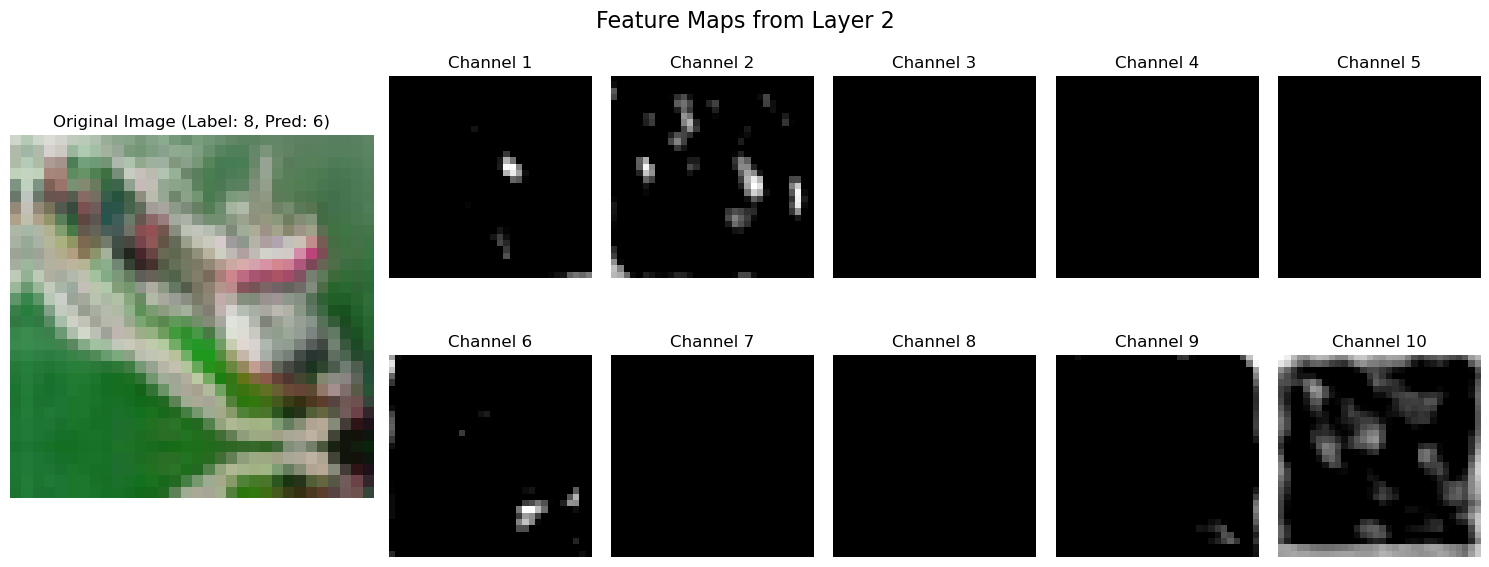

In [54]:
# Set Hyperparameters
batch_size_cifar10 = 256
epochs_cifar10 = 45
learning_rate_cifar10 = 0.01

# Mean and std for CIFAR10
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)

# Data augmentation and pre-processing for CIFAR-10
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# Just convert to tensor and normalize for validation and test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# Retrieve the CIFAR-10 dataset from PyTorch
full_train_cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data_cifar10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=train_transform)

# Split the data into training (45000) and validation (5000)
train_size_cifar10 = 45000
val_size_cifar10   = 5000
train_data_cifar10, val_data_cifar10 = random_split(full_train_cifar10, [train_size_cifar10, val_size_cifar10], generator=torch.Generator().manual_seed(42))

# Dataloaders
train_loader_cifar10 = DataLoader(train_data_cifar10, batch_size=batch_size_cifar10, shuffle=True)
val_loader_cifar10   = DataLoader(val_data_cifar10, batch_size=batch_size_cifar10, shuffle=False)
test_loader_cifar10  = DataLoader(test_data_cifar10, batch_size=batch_size_cifar10, shuffle=False)

# Declare the model for CIFAR-10
model = CNNClassCIFAR10(
    input_channel=3,
    filter_size=5,
    stride=1,
    num_classes=10
).to(device)

# Train the model
train_losses, val_losses, test_losses, train_accs, val_accs, test_accs = train_model(
    model,
    device,
    train_loader_cifar10,
    val_loader_cifar10,
    test_loader_cifar10,
    learning_rate_cifar10,
    epochs_cifar10,
    weight_decay=1e-4,
    use_lr_scheduler=True
)

# Plot the loss and accuracy curve + the histogram for weights and biases
plot_curve_and_histogram(model, train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, mnist=False)

# Visualize some correctly predicted image and incorrectly predicted image
correct_images, correct_labels, correct_preds, incorrect_images, incorrect_labels, incorrect_preds = visualize_predictions(model, test_loader_cifar10, device, cifar=True)

# Visualize the feature maps for some channels (for correct prediction)
visualize_feature_maps_side_by_side(model, correct_images[0], correct_labels[0], correct_preds[0], device, cifar=True)

# Visualize the feature maps for some channels (for incorrect prediction)
visualize_feature_maps_side_by_side(model, incorrect_images[0], incorrect_labels[0], incorrect_preds[0], device, cifar=True)